In [1]:
from jax.random import PRNGKey
import jax
import jax.numpy as jnp
import jax.random as jr

import gymnax
import matplotlib.pyplot as plt
from functools import partial

%matplotlib inline

In [2]:
# Define the environment in which we want to learn
env, env_params = gymnax.make('Pendulum-v1')

action_list = jnp.array([-1., 0., 1.])
num_actions = len(action_list)

num_obs = 3
# obs = (x = cos(theta), y = sin(theta), angular velocity)

In [3]:
def initialize_theta(layer_sizes, mean, std):
    """
    Inputs:
        layer_sizes (tuple): Tuple of shapes of the neural network layers
        mean (float): mean of all variables at the start
        std (float): standard deviation of all variables at the start

    Return:
        mean (List): Tuple of mean for weights and biases per layer
        std (List): Tuple of std for weights and biases per layer
        [(weights_1, biases_1), ..., (weights_n, biases_n)]
    """

    means = []
    stds = []

    for i in range(len(layer_sizes) - 1):
        means.append((
            jnp.full((layer_sizes[i], layer_sizes[i + 1]), mean),
            jnp.full((layer_sizes[i + 1],), mean)
        ))
        stds.append((
            jnp.full((layer_sizes[i], layer_sizes[i + 1]), std),
            jnp.full((layer_sizes[i + 1],), std)
        ))

    return means, stds


@partial(jax.jit, static_argnames=['layer_sizes'])
def initialize_mlp(layer_sizes, key:PRNGKey, means, stds):
    """
    Inputs:
        layer_sizes (tuple): Tuple of shapes of the neural network layers
        key (PRNGKey):
        mean (List): mean of all variables
        std (List): standard deviation of all variables

    Return:
        params (List): Tuple of weights and biases per layer
        [(weights_1, biases_1), ..., (weights_n, biases_n)]
    """

    params = []

    for (i, subkey), mean, std in zip(enumerate(jr.split(key, len(layer_sizes) - 1)), means, stds):
        mean_weights, mean_biases = mean
        std_weights, std_biases = std

        key1, key2 = jr.split(subkey)

        params.append((  # weights_i, biases_i
            mean_weights + std_weights * jr.normal(key1, shape=(layer_sizes[i], layer_sizes[i + 1])),
            mean_biases + std_biases * jr.normal(key2, shape=(layer_sizes[i + 1],))
        ))

    return params

    # params = [(weights_1, biases_1), ..., (weights_n, biases_n)]
    # [([3, 5], [5]), ([5, 3], [3])] if layer_sizes = (num_obs, 5, num_actions) = (3, 5, 3)


@jax.jit
def policy(params, x):
    """ Standard MLP that predicts either -1, 0, 1

    Inputs:
        params (PyTree): Parameters of the current network
        x (num_obs,): input state
    """

    # Forward feed until the last layer
    for w, b in params[:-1]:
        x = jax.nn.relu(x @ w + b)

    # Forward feed the last layer
    w, b = params[-1]
    x = jax.nn.softmax(x @ w + b)

    return x


@jax.jit
def get_action(params, x, key:PRNGKey):
    """
    Sample an action using the action probabilities predicted by the MLP

    Input:
        params (PyTree):
        x (num_obs,): input state
        key (PRNGKey):

    Return:
        action (action_list element): action generated according to params
        action_idx (action_list index): indices of actions generated according to params
    """

    action_idx = jr.choice(key, num_actions, p=policy(params, x))
    action = -1.0 + 2.0 / (num_actions - 1) * action_idx
    return action, action_idx


@partial(jax.jit, static_argnames=['env_params', 'steps_in_episode'])
def rollout(params, env_params, key:PRNGKey, steps_in_episode:int):
    """Rollout a jitted gymnax episode with lax.scan"""

    # Reset the environment
    rng_reset, rng_episode = jr.split(key)
    obs, state = env.reset(rng_reset, env_params)

    def policy_step(state_input, tmp):
        # lax.scan compatible step transition in jax env
        obs, state, rng = state_input
        rng, rng_action, rng_step = jr.split(rng, 3)
        action, action_idx = get_action(params, obs, rng_action)
        next_obs, next_state, reward, done, _ = env.step(rng_step, state, action, env_params)
        carry = [next_obs, next_state, rng]
        return carry, [obs, state, action, action_idx, reward, next_obs, done]

    # Scan over episode step loop
    _, scan_out = jax.lax.scan(
      policy_step,
      [obs, state, rng_episode],
      (),
      length=steps_in_episode,
    )
    return scan_out

    # obs, state, action, action_idx, reward, next_obs, done = \
    # rollout(params, env_params, rng_input=key, steps_in_episode=env_params.max_steps_in_episode)

In [4]:
def visualize_trajectory(params, key):
    obs, state, action, action_idx, reward, next_obs, done = rollout(params, env_params, key, env_params.max_steps_in_episode)
    ts = jnp.arange(0, env_params.dt * env_params.max_steps_in_episode, env_params.dt)

    fig, ax = plt.subplots(5,1,figsize=(8,8))
    ax[0].set_title('System states over time')

    for d in range(env.obs_shape[0]):
        ax[d].plot(ts, obs[:,d], color='C0', label=f'State {d}')

    ax[0].set_title(r'$\cos(\theta)$')
    ax[1].set_title(r'$\sin(\theta)$')
    ax[2].set_title(r'$\dot{\theta}$')

    ax[3].plot(ts, action, color='C1', label=f'Actions')
    ax[4].plot(ts, reward, color='C2', label='Rewards')

    ax[3].set_title('u(t)')
    ax[4].set_title('r(t)')

    plt.tight_layout()
    plt.show()

In [5]:
# Compute the cumulative reward for all samples in the population using the given key
@partial(jax.jit, static_argnames=['gamma', 'layer_sizes', 'population_size', 'env_params'])
def cum_rewards(population, key, gamma, layer_sizes, population_size, env_params):
    parallel_rollout = jax.vmap(rollout, in_axes=([(0, 0)] * (len(layer_sizes) - 1), None, 0, None))

    subkeys = jr.split(key, population_size)
    _, _, _, _, rewards, _, _= parallel_rollout(population, env_params, subkeys, env_params.max_steps_in_episode)

    # Compute the cumulative reward from the reward traces
    cum_reward = lambda reward: jax.lax.scan(lambda cum_reward, curr_reward: (cum_reward * gamma + curr_reward, 0), 0, reward)
    cum_rewards = jax.vmap(cum_reward, in_axes=0, out_axes=(0, None))(rewards)[0]

    return cum_rewards


# Compute the cumulative rewards num_batches times and take the means
@partial(jax.jit, static_argnames=['num_batches', 'gamma', 'layer_sizes', 'population_size', 'env_params'])
def compute_cum_rewards(population, key, num_batches, gamma, layer_sizes, population_size, env_params):
    subkeys = jr.split(key, num_batches + 1)
    batched_cum_rewards = jax.vmap(
        cum_rewards,
        in_axes=(None, 0, None, None, None, None)
    )(population, jnp.array(subkeys), gamma, layer_sizes, population_size, env_params)
    return jnp.mean(batched_cum_rewards, axis=0)


# Construct the new mean and standard deviation for all variables in the network
@partial(jax.jit, static_argnames=['topk', 'layer_sizes'])
def improve(population, means, stds, topk, topk_indices, layer_sizes):
    new_means = []
    new_stds = []

    # Go over each layer to construct a new mean and std
    for layer in range(len(layer_sizes) - 1):
        topk_weights = population[layer][0][topk_indices]
        topk_biases = population[layer][1][topk_indices]

        mean_weights, mean_biases = means[layer]
        std_weights, std_biases = stds[layer]

        new_mean_weights = jnp.sum(topk_weights, axis=0) / topk
        new_mean_biases = jnp.sum(topk_biases, axis=0) / topk

        new_std_weights = jnp.sqrt(jnp.sum(
            jnp.array([jnp.power(top_std_weights - mean_weights, 2) for top_std_weights in topk_weights]), axis=0) / topk)
        new_std_biases = jnp.sqrt(jnp.sum(
            jnp.array([jnp.power(top_std_biases - mean_biases, 2) for top_std_biases in topk_biases]), axis=0) / topk)

        new_means.append((new_mean_weights, new_mean_biases))
        new_stds.append((new_std_weights, new_std_biases))

    return new_means, new_stds


# Train the network
@partial(jax.jit, static_argnames=['num_iters', 'num_batches', 'gamma', 'topk', 'layer_sizes', 'population_size', 'env_params'])
def train(key, means, stds, num_iters, num_batches, gamma, topk, layer_sizes, population_size, env_params):
    def step(carry, _):
        key, means, stds = carry

        # Generate all the samples for in the population
        key, *subkeys = jr.split(key, population_size + 1)
        population = jax.vmap(initialize_mlp, in_axes=(None, 0, None, None))(layer_sizes, jnp.array(subkeys), means, stds)

        # Compute the rewards/loss for all samples in the population
        key, subkey = jr.split(key, 2)
        rewards = compute_cum_rewards(population, subkey, num_batches, gamma, layer_sizes, population_size, env_params)

        # Extract the top K samples (linear time performance)
        topk_indices = jnp.argpartition(rewards, -topk)[-topk:]

        # Save the average loss for the top K samples
        loss = jnp.mean(rewards[topk_indices])
        # Compute the new best variables
        means, stds = improve(population, means, stds, topk, topk_indices, layer_sizes)

        return (key, means, stds), loss

    (_, means, _stds), history = jax.lax.scan(
        step,
        (key, means, stds),
        None,
        length=num_iters
    )
    return history, means

In [6]:
key = PRNGKey(1337)

# Create the population of networks using the following settings
layer_sizes = (num_obs, 10, num_actions)
population_size = 100

# 'means' and 'stds' hold the elite set information
means, stds = initialize_theta(layer_sizes, mean=0, std=100)

gamma = 0.99       # discounting factor for reward
topk = 10          # select top K to produce a new population
num_batches = 50   # the number of rollouts done per sample
num_iters = 200    # number of evolution iterations

assert topk <= population_size

history, model = train(key, means, stds, num_iters, num_batches, gamma, topk, layer_sizes, population_size, env_params)

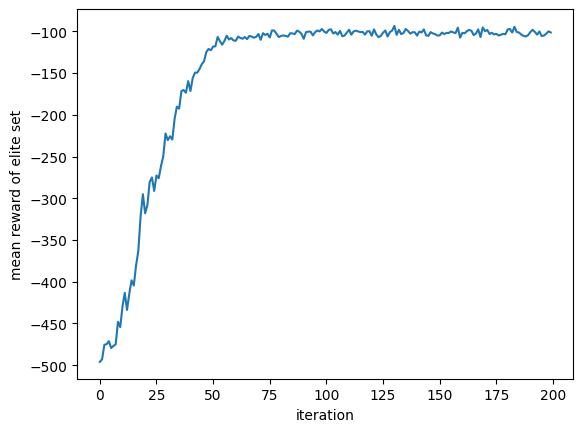

<Figure size 640x480 with 0 Axes>

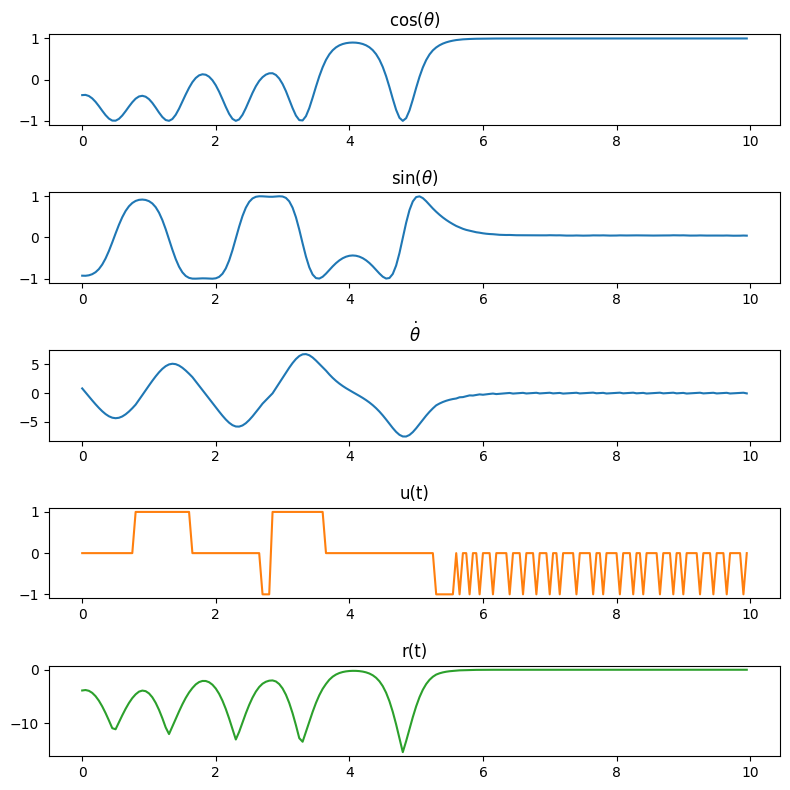

In [7]:
plt.plot(history)

plt.xlabel('iteration')
plt.ylabel('mean reward of elite set')
plt.show()

key, subkey = jr.split(key)
visualize_trajectory(model, subkey)